Testing an idea: 

#### First: 
Learn the latent manifold of 3 and 7, and 3&7

#### Second:
Do the variational learning.
The loss function would be
$$
l_i(\theta, \phi) = - \mathbb{E}_{z \sim q_{\theta}(z|x_i)} [\log p_{\phi} (x_i | z^{(3)}, z^{(7)})]  + KL(q_{\theta_{(3)}}^{(3)}(z^{(3)} | x_i^{(3)}) q_{\theta_{(7)}}^{(7)}(z^{(7)} | x_i^{(7)}) || p(z)) 
$$
where

- $p(z)$ is the true prior distribution of 3+7

The expectaion part can be written (in code):
```{python}
-tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean) + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean) , 1)
```
where 
- self.x is the original mixture data of "3" and "7".
- self.x_reconstr_mean is an addition of the two outputs, which are decoded from a sampling in the learned $z^{(3)}$ and $z^{(7)}$ space. 

The KL divergence part can be interpreted as 

The mixing image part is like adding two random variables together. Suppose we have $X_3$ and $X_7$, where $X_3 \sim p_3(x | z^{(3)})$ and $X_7 \sim p_7(x | z^{(7)})$ 

Then, the distribution of $X_3 + X_7$ follows Poisson-Binomial distribution with n = 2. (?) 

But what about the hidden space? The prior distribution of the hidden space is Gaussian. So should we let...

The above problem is solved. Please see the 2016/08/22 notes from my research notebook.

In [8]:
import numpy as np
import tensorflow as tf
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [385]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.network_weights = network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluatio of log(0.0)
        self.reconstr_loss = reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-4 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-4 + 1 - self.x_reconstr_mean),
                           1)
        # self.reconstr_loss = reconstr_loss = tf.Print(reconstr_loss, [reconstr_loss], message="This is reconstr_loss: ")
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        self.latent_loss = latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        # self.latent_loss = latent_loss = tf.Print(latent_loss, [latent_loss], message="This is latent_loss: ")
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def debug(self, X):
        re, la = self.sess.run((self.reconstr_loss, self.latent_loss), feed_dict={self.x: X})
        return (re, la)
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    
    def restoreWeights(self, weights_dict):
        assign_op1 = self.network_weights["weights_recog"]["h1"].assign(weights_dict["weights_recog"]["h1"])
        assign_op2 = self.network_weights["weights_recog"]["h2"].assign(weights_dict["weights_recog"]["h2"])
        assign_op3 = self.network_weights["weights_recog"]["out_mean"].assign(weights_dict["weights_recog"]["out_mean"])
        assign_op4 = self.network_weights["weights_recog"]["out_log_sigma"].assign(weights_dict["weights_recog"]["out_log_sigma"])
        self.sess.run([assign_op1, assign_op2, assign_op3, assign_op4])
        assign_op1 = self.network_weights["biases_recog"]["b1"].assign(weights_dict["biases_recog"]["b1"])
        assign_op2 = self.network_weights["biases_recog"]["b2"].assign(weights_dict["biases_recog"]["b2"])
        assign_op3 = self.network_weights["biases_recog"]["out_mean"].assign(weights_dict["biases_recog"]["out_mean"])
        assign_op4 = self.network_weights["biases_recog"]["out_log_sigma"].assign(weights_dict["biases_recog"]["out_log_sigma"])
        self.sess.run([assign_op1, assign_op2, assign_op3, assign_op4])
        assign_op1 = self.network_weights["weights_gener"]["h1"].assign(weights_dict["weights_gener"]["h1"])
        assign_op2 = self.network_weights["weights_gener"]["h2"].assign(weights_dict["weights_gener"]["h2"])
        assign_op3 = self.network_weights["weights_gener"]["out_mean"].assign(weights_dict["weights_gener"]["out_mean"])
        assign_op4 = self.network_weights["weights_gener"]["out_log_sigma"].assign(weights_dict["weights_gener"]["out_log_sigma"])
        self.sess.run([assign_op1, assign_op2, assign_op3, assign_op4])
        assign_op1 = self.network_weights["biases_gener"]["b1"].assign(weights_dict["biases_gener"]["b1"])
        assign_op2 = self.network_weights["biases_gener"]["b2"].assign(weights_dict["biases_gener"]["b2"])
        assign_op3 = self.network_weights["biases_gener"]["out_mean"].assign(weights_dict["biases_gener"]["out_mean"])
        assign_op4 = self.network_weights["biases_gener"]["out_log_sigma"].assign(weights_dict["biases_gener"]["out_log_sigma"])
        self.sess.run([assign_op1, assign_op2, assign_op3, assign_op4])
    
    def getWeights(self):
        all_weights = dict() 
        all_weights['weights_recog'] = {
            'h1': self.sess.run(self.network_weights['weights_recog']['h1']),
            'h2': self.sess.run(self.network_weights['weights_recog']['h2']),
            'out_mean': self.sess.run(self.network_weights['weights_recog']['out_mean']),
            'out_log_sigma': self.sess.run(self.network_weights['weights_recog']['out_log_sigma'])}
        all_weights['biases_recog'] = {
            'b1': self.sess.run(self.network_weights['biases_recog']['b1']),
            'b2': self.sess.run(self.network_weights['biases_recog']['b2']),
            'out_mean': self.sess.run(self.network_weights['biases_recog']['out_mean']),
            'out_log_sigma': self.sess.run(self.network_weights['biases_recog']['out_log_sigma'])}
        all_weights['weights_gener'] = {
            'h1': self.sess.run(self.network_weights['weights_gener']['h1']), 
            'h2': self.sess.run(self.network_weights['weights_gener']['h2']), 
            'out_mean': self.sess.run(self.network_weights['weights_gener']['out_mean']), 
            'out_log_sigma': self.sess.run(self.network_weights['weights_gener']['out_log_sigma'])}
        all_weights['biases_gener'] = {
            'b1': self.sess.run(self.network_weights['biases_gener']['b1']),
            'b2': self.sess.run(self.network_weights['biases_gener']['b2']),
            'out_mean': self.sess.run(self.network_weights['biases_gener']['out_mean']),
            'out_log_sigma': self.sess.run(self.network_weights['biases_gener']['out_log_sigma'])}
        return all_weights 

In [21]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [23]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 177.487866155
Epoch: 0006 cost= 109.325325845
Epoch: 0011 cost= 104.702248064
Epoch: 0016 cost= 102.541683072
Epoch: 0021 cost= 101.161696195
Epoch: 0026 cost= 100.068779047
Epoch: 0031 cost= 99.058124528
Epoch: 0036 cost= 98.247012801
Epoch: 0041 cost= 97.626852625
Epoch: 0046 cost= 97.102496657
Epoch: 0051 cost= 96.665673953
Epoch: 0056 cost= 96.283067655
Epoch: 0061 cost= 95.918288422
Epoch: 0066 cost= 95.628499451
Epoch: 0071 cost= 95.372495755


Exception ignored in: <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x109813978>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 178, in __del__
    self.close()
  File "/usr/local/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 1028, in close
    self._default_session.__exit__(None, None, None)
  File "/usr/local/Cellar/python3/3.4.3_2/Frameworks/Python.framework/Versions/3.4/lib/python3.4/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 3529, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects


In [24]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

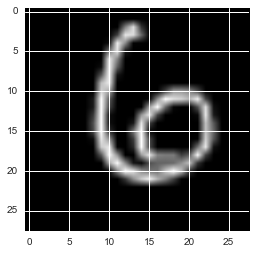

In [25]:
#% matplotlib inline
pltout = plt.imshow(x_sample[0].reshape(28, 28), cmap="gray") 
#pltout = plt.imshow(x_reconstruct[0].reshape(28, 28), cmap="gray")

In [26]:
weights_mnist = vae.getWeights()

In [32]:
import pickle
with open("BayesMixNet/mnist_weights_ae.pickle", "wb") as f:
    pickle.dump(weights_mnist, f)

# Generate Synthesize Data

In [ ]:
# Triangle + Rectangle image generator
# You can check an example of the images like this:
# % matplotlib inline 
# images, alphas = generateSynthetic(10)
# print(images.shape)
# print(alphas[1])
# plt_out = plt.imshow(images[1].reshape(28,28), cmap="gray")
def generateSynthetic(n): # n = training examples
    size = 28
    image_store = np.zeros([n, 784])
    for i in range(n):
        # triangle
        im = Image.new('L', (28, 28))
        draw = ImageDraw.Draw(im)
        draw.polygon([(0, 0), (0, 28), (28, 28), (28, 0)], fill = 'black')
        draw.polygon([(13,3), (25, 15), (1,15)], fill = 'white') 
        triangle = np.asarray( im, dtype="float32" )

        im = Image.new('L', (28, 28))
        draw = ImageDraw.Draw(im)
        draw.polygon([(0, 0), (0, 28), (28, 28), (28, 0)], fill = 'black')
        draw.polygon([(4,10), (23, 10), (23, 23), (4, 23)], fill = 'white') 
        rectangle = np.asarray( im, dtype="float32" )   

        alpha = np.random.uniform(0,1)
        synthetic = np.clip(alpha*triangle + (1-alpha)*rectangle, 0, 255)
        image_store[i] = synthetic.reshape(784)
        alpha_list.append(alpha)
    
    return image_store, alpha_list
    

## Trianlge drawing test

(28, 28)


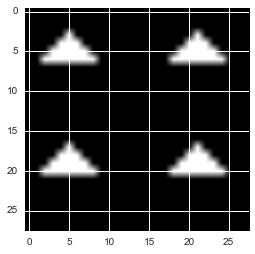

In [133]:
from PIL import Image, ImageDraw 
# triangle
im = Image.new('L', (28, 28))
draw = ImageDraw.Draw(im)
draw.polygon([(0, 0), (0, 28), (28, 28), (28, 0)], fill = 'black')
a = (5,3); b = (8,6); c = (2,6)
draw.polygon([a,b,c], fill = 'white') # (13,3), (25, 15), (1,15)
draw.polygon([(21,3), (18, 6), (24,6)], fill = 'white') # (13,3), (25, 15), (1,15)
draw.polygon([(21,17), (18, 20), (24,20)], fill = 'white')
draw.polygon([(5,17), (8, 20), (2,20)], fill = 'white') # (13,3), (25, 15), (1,15)
triangle = np.asarray( im, dtype="float32" )

% matplotlib inline 
print(triangle.shape)
plt_out = plt.imshow(triangle.reshape(28,28), cmap="gray")

In [170]:
def getTriangle(n_circle, n):
    image_list = []
    pos_dict = [
            [(5,3), (8,6), (2,6)],
            [(21,3),(18, 6),(24,6)],
            [(21,17), (18, 20), (24,20)],
            [(5,17), (8, 20), (2,20)]
    ]
    for i in range(n):
        if n_circle == 2:
            pos_id = np.random.randint(6) # choosing which set of points we use; there are 4 possibilities of positioning three triangles.
            if pos_id == 0:
                x1,y1,r1 = pos_dict[0]; x2,y2,r2 = pos_dict[1]; 
            if pos_id == 1:
                x1,y1,r1 = pos_dict[0]; x2,y2,r2 = pos_dict[2]; 
            if pos_id == 2:
                x1,y1,r1 = pos_dict[0]; x2,y2,r2 = pos_dict[3]; 
            if pos_id == 3:
                x1,y1,r1 = pos_dict[1]; x2,y2,r2 = pos_dict[2]; 
            if pos_id == 4:
                x1,y1,r1 = pos_dict[1]; x2,y2,r2 = pos_dict[3]; 
            if pos_id == 5:
                x1,y1,r1 = pos_dict[2]; x2,y2,r2 = pos_dict[3]; 
            
            im = Image.new('L', (28, 28))
            draw = ImageDraw.Draw(im)
            draw.polygon([(0, 0), (0, 28), (28, 28), (28, 0)], fill = 'black')
            
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            x1 = list(x1); r1 = list(r1); y1 = list(y1)
            r1[0] += dr; x1[0] += dx; y1[0] += dy
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r1[1]  += dr; x1[1] += dx; y1[1] += dy
            x1 = tuple(x1); r1 = tuple(r1); y1 = tuple(y1)
            draw.polygon([x1,y1,r1], fill = 'white')
            
            x2 = list(x2); r2 = list(r2); y2 = list(y2)
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r2[0]  += dr; x2[0] += dx; y2[0] += dy
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r2[1]  += dr; x2[1] += dx; y2[1] += dy
            x2 = tuple(x2); r2 = tuple(r2); y2 = tuple(y2)
            draw.polygon([x2,y2,r2], fill = 'white')
                     
            triangle = np.asarray( im, dtype="float32" )
            image_list.append(triangle)
            
        if n_circle == 3:
            pos_id = np.random.randint(4) # choosing which set of points we use; there are 4 possibilities of positioning three triangles.
            if pos_id == 0:
                x1,y1,r1 = pos_dict[1]; x2,y2,r2 = pos_dict[2]; x3,y3,r3 = pos_dict[3];
            if pos_id == 1:
                x1,y1,r1 = pos_dict[0]; x2,y2,r2 = pos_dict[2]; x3,y3,r3 = pos_dict[3];
            if pos_id == 2:
                x1,y1,r1 = pos_dict[0]; x2,y2,r2 = pos_dict[1]; x3,y3,r3 = pos_dict[3];
            if pos_id == 3:
                x1,y1,r1 = pos_dict[0]; x2,y2,r2 = pos_dict[1]; x3,y3,r3 = pos_dict[2];
            
            im = Image.new('L', (28, 28))
            draw = ImageDraw.Draw(im)
            draw.polygon([(0, 0), (0, 28), (28, 28), (28, 0)], fill = 'black')
            
            x1 = list(x1); r1 = list(r1); y1 = list(y1)
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r1[0]  += dr; x1[0] += dx; y1[0] += dy
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r1[1]  += dr; x1[1] += dx; y1[1] += dy
            x1 = tuple(x1); r1 = tuple(r1); y1 = tuple(y1)
            draw.polygon([x1,y1,r1], fill = 'white')
            
            x2 = list(x2); r2 = list(r2); y2 = list(y2)
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r2[0]  += dr; x2[0] += dx; y2[0] += dy
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r2[1]  += dr; x2[1] += dx; y2[1] += dy
            x2 = tuple(x2); r2 = tuple(r2); y2 = tuple(y2)
            draw.polygon([x2,y2,r2], fill = 'white')

            x3 = list(x3); r3 = list(r3); y3 = list(y3)
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r3[0]  += dr; x3[0] += dx; y3[0] += dy
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r3[1]  += dr; x3[1] += dx; y3[1] += dy
            x3 = tuple(x3); r3 = tuple(r3); y3 = tuple(y3)
            draw.polygon([x3,y3,r3], fill = 'white')
                     
            triangle = np.asarray( im, dtype="float32" )
            image_list.append(triangle)
            
        if n_circle == 4:
            x1 = (5,3); y1 = (8,6); r1 = (2,6)
            x2 = (21,3); y2 =  (18, 6); r2 = (24,6)
            x3 = (21,17); y3 = (18, 20); r3 = (24,20)
            x4 = (5,17); y4 = (8, 20); r4 = (2,20)

            im = Image.new('L', (28, 28))
            draw = ImageDraw.Draw(im)
            draw.polygon([(0, 0), (0, 28), (28, 28), (28, 0)], fill = 'black')
            
            x1 = list(x1); r1 = list(r1); y1 = list(y1)
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r1[0]  += dr; x1[0] += dx; y1[0] += dy
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r1[1]  += dr; x1[1] += dx; y1[1] += dy
            x1 = tuple(x1); r1 = tuple(r1); y1 = tuple(y1)
            draw.polygon([x1,y1,r1], fill = 'white')
            
            x2 = list(x2); r2 = list(r2); y2 = list(y2)
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r2[0]  += dr; x2[0] += dx; y2[0] += dy
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r2[1]  += dr; x2[1] += dx; y2[1] += dy
            x2 = tuple(x2); r2 = tuple(r2); y2 = tuple(y2)
            draw.polygon([x2,y2,r2], fill = 'white')
            
            x3 = list(x3); r3 = list(r3); y3 = list(y3)
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r3[0]  += dr; x3[0] += dx; y3[0] += dy
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r3[1]  += dr; x3[1] += dx; y3[1] += dy
            x3 = tuple(x3); r3 = tuple(r3); y3 = tuple(y3)
            draw.polygon([x3,y3,r3], fill = 'white')
            
            x4 = list(x4); r4 = list(r4); y4 = list(y4)
            dr = np.random.randint(3); dx = np.random.randint(3); dy = np.random.randint(3)
            r4[0]  += dr; x4[0] += dx; y4[0] += dy
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r4[1]  += dr; x4[1] += dx; y4[1] += dy
            x4 = tuple(x4); r4 = tuple(r4); y4 = tuple(y4)
            draw.polygon([x4,y4,r4], fill = 'white')     
                     
            triangle = np.asarray( im, dtype="float32" )
            image_list.append(triangle)

    return np.array(image_list).reshape(-1, 784)

In [146]:
triangles = getTriangle(n_circle=3, n=10)

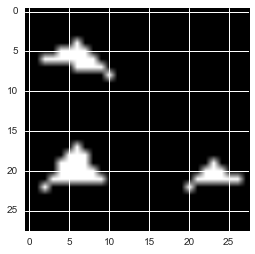

In [151]:
% matplotlib inline 
# print(triangle.shape)
plt_out = plt.imshow(triangles[7].reshape(28,28), cmap="gray")

## Circle drawing test

In [169]:
def getCircle(n_circle, n):
    image_list = []
    for i in range(n):
        if n_circle == 2:
            r = 2; x1 = 5; y1 = 5
            r = 2; x2 = 20; y2 = 20
            im = Image.new('L', (28, 28))
            draw = ImageDraw.Draw(im)
            draw.polygon([(0, 0), (0, 28), (28, 28), (28, 0)], fill = 'black')
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r  += dr; x1 += dx; y1 += dy 
            draw.ellipse((x1-r, y1-r, x1+r, y1+r), fill = 'white') # (x1, y1, x2, y2) (x-r, y-r, x+r, y+r)
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r  += dr; x2 += dx; y2 += dy         
            draw.ellipse((x2-r, y2-r, x2+r, y2+r), fill = 'white') # (x1, y1, x2, y2) (x-r, y-r, x+r, y+r)
            triangle = np.asarray( im, dtype="float32" )
            image_list.append(triangle)
        if n_circle == 3:
            r1 = 2; x1 = 5; y1 = 14
            r2 = 2; x2 = 18; y2 = 5
            r3 = 2; x3 = 20; y3 = 20
            im = Image.new('L', (28, 28))
            draw = ImageDraw.Draw(im)
            draw.polygon([(0, 0), (0, 28), (28, 28), (28, 0)], fill = 'black')
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r1  += dr; x1 += dx; y1 += dy 
            draw.ellipse((x1-r1, y1-r1, x1+r1, y1+r1), fill = 'white') # (x1, y1, x2, y2) (x-r, y-r, x+r, y+r)
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r2  += dr; x2 += dx; y2 += dy         
            draw.ellipse((x2-r2, y2-r2, x2+r2, y2+r2), fill = 'white') # (x1, y1, x2, y2) (x-r, y-r, x+r, y+r)
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r3  += dr; x3 += dx; y3 += dy         
            draw.ellipse((x3-r3, y3-r3, x3+r3, y3+r3), fill = 'white') # (x1, y1, x2, y2) (x-r, y-r, x+r, y+r)
            triangle = np.asarray( im, dtype="float32" )
            image_list.append(triangle)

        if n_circle == 4:
            r1 = 2; x1 = 5; y1 = 5
            r2 = 2; x2 = 18; y2 = 5
            r3 = 2; x3 = 20; y3 = 21
            r4 = 2; x4 = 5; y4 = 20
            im = Image.new('L', (28, 28))
            draw = ImageDraw.Draw(im)
            draw.polygon([(0, 0), (0, 28), (28, 28), (28, 0)], fill = 'black')
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r1  += dr; x1 += dx; y1 += dy 
            draw.ellipse((x1-r1, y1-r1, x1+r1, y1+r1), fill = 'white') # (x1, y1, x2, y2) (x-r, y-r, x+r, y+r)
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r2  += dr; x2 += dx; y2 += dy         
            draw.ellipse((x2-r2, y2-r2, x2+r2, y2+r2), fill = 'white') # (x1, y1, x2, y2) (x-r, y-r, x+r, y+r)
            dr = np.random.randint(2); dx = np.random.randint(3); dy = np.random.randint(3)
            r3  += dr; x3 += dx; y3 += dy         
            draw.ellipse((x3-r3, y3-r3, x3+r3, y3+r3), fill = 'white') # (x1, y1, x2, y2) (x-r, y-r, x+r, y+r)
            r4  += dr; x4 += dx; y4 += dy         
            draw.ellipse((x4-r4, y4-r4, x4+r4, y4+r4), fill = 'white')
            triangle = np.asarray( im, dtype="float32" )
            image_list.append(triangle)

    return np.array(image_list).reshape(-1, 784)

In [153]:
circles = getCircle(n_circle=3, n=10)

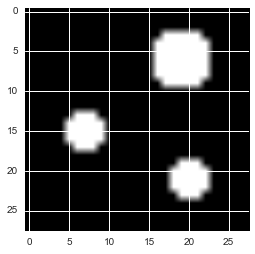

In [156]:
% matplotlib inline 
# print(triangle.shape)
plt_out = plt.imshow(circles[8].reshape(28,28), cmap="gray")

# Save the synthetic data

In [181]:
import pickle
# training samples 50000 test samples 10000
# triangle {2,3,4} circles {2,3,4}
syn_data = np.zeros([10000, 784])
fro = 0
to = 1666
for i in range(3):
    print(fro)
    print(to)
    syn_data[fro:to] = getTriangle(n_circle=(i+2), n=1666)
    fro += 1666
    to += 1666
for i in range(3):
    print(fro)
    print(to)
    syn_data[fro:to] = getCircle(n_circle=(i+2), n=1666)
    fro += 1666
    to += 1666

0
1666
1666
3332
3332
4998
4998
6664
6664
8330
8330
9996


In [182]:
syn_data[9996:] = getCircle(n_circle=4, n=4)

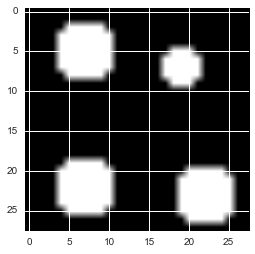

In [184]:
% matplotlib inline
a = plt.imshow(syn_data[9999].reshape(28, 28), cmap="gray")

In [185]:
import pickle
with open("./BayesMixNet/syn_data_test.pickle", "wb") as f:
    pickle.dump(syn_data, f)

In [187]:
import pickle
# training samples 50000 test samples 10000
# triangle {2,3,4} circles {2,3,4}
syn_data = np.zeros([50000, 784])
step = 8333
fro = 0
to = step
for i in range(3):
    print(fro)
    print(to)
    syn_data[fro:to] = getTriangle(n_circle=(i+2), n=step)
    fro += step
    to += step
for i in range(3):
    print(fro)
    print(to)
    syn_data[fro:to] = getCircle(n_circle=(i+2), n=step)
    fro += step
    to += step

0
8333
8333
16666
16666
24999
24999
33332
33332
41665
41665
49998


In [188]:
syn_data[49998:] = getCircle(n_circle=4, n=2)

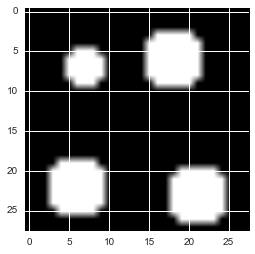

In [189]:
% matplotlib inline
a = plt.imshow(syn_data[49999].reshape(28, 28), cmap="gray")

In [190]:
import pickle
with open("./BayesMixNet/syn_data_train.pickle", "wb") as f:
    pickle.dump(syn_data, f)

# Train VAE on Synthetic Data

In [220]:
with open("./BayesMixNet/syn_data_train.pickle", "rb") as f:
    syn_data_train = pickle.load(f)    

In [221]:
n_samples = syn_data_train.shape[0]
n_samples

50000

In [222]:
np.random.shuffle(syn_data_train)

In [223]:
syn_data_train.shape

(50000, 784)

## Normalization

In [257]:
syn_data_train /= 255

In [260]:
print(np.mean(syn_data_train))
print(np.std(syn_data_train))

0.0917274234694
0.288640785845


In [261]:
def normalizeData(patches):
    # subtract its mean and truncate it  to -/+3*std
    patches = patches - np.mean(patches)
    pstd = np.std(patches)
    patches = np.clip(patches, -pstd, pstd) / pstd
    
    # rescale from [-1, 1] to [0.1, 0.9] 
    # patches = (patches + 1) * 0.4 + 0.1
    return patches

In [262]:
syn_data_train = normalizeData(syn_data_train)

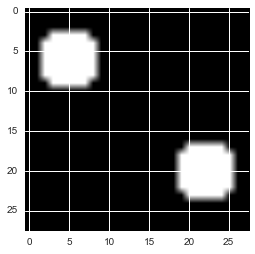

In [263]:
p = plt.imshow(syn_data_train[1].reshape(28, 28), cmap="gray")

In [256]:
np.max(syn_data_train[0])

255.0

In [15]:
def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)] 

In [386]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    with tf.Graph().as_default():
        vae = VariationalAutoencoder(network_architecture, 
                                     learning_rate=learning_rate, 
                                     batch_size=batch_size)
        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(n_samples / batch_size)
            # Loop over all batches
            for i in range(total_batch):
                # batch_xs, _ = mnist.train.next_batch(batch_size)
                batch_xs = get_random_block_from_data(syn_data_train, batch_size)

                # Fit training using batch data
#                 if epoch >= 3:
#                     re, la = vae.debug(batch_xs)
#                     print(re)
#                     print(la)
                cost = vae.partial_fit(batch_xs)
                # Compute average loss
                avg_cost += cost / n_samples * batch_size

            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), \
                      "cost=", "{:.9f}".format(avg_cost))
    return vae

In [384]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        a = tf.log(1e-4)
        print(sess.run(a))

-9.21034


In [379]:
4400 / 784

5.612244897959184

In [501]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, learning_rate = 0.001, training_epochs=10)

Epoch: 0001 cost= -1666.214838020
Epoch: 0006 cost= -1917.210370117


Exception ignored in: <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x11fa4b470>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 178, in __del__
    self.close()
  File "/usr/local/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 1028, in close
    self._default_session.__exit__(None, None, None)
  File "/usr/local/Cellar/python3/3.4.3_2/Frameworks/Python.framework/Versions/3.4/lib/python3.4/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 3529, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects


In [271]:
with open("./BayesMixNet/syn_data_test.pickle", "rb") as f:
    syn_data_test = pickle.load(f)

In [272]:
syn_data_test /= 255
syn_data_test = normalizeData(syn_data_test)

In [326]:
np.random.shuffle(syn_data_test)

In [502]:
x_sample = syn_data_test[:100] # mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

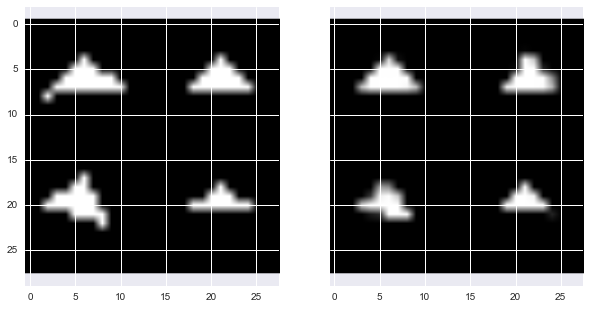

In [509]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
i = 50
plt_ = axes[0].imshow(x_sample[i].reshape(28, 28), cmap="gray")
plt_ = axes[1].imshow(x_reconstruct[i].reshape(28, 28), cmap="gray") 

# TO DO: save the network weights for Synthesized and start building the mix net

In [510]:
weights_syn = vae.getWeights()
import pickle
with open("BayesMixNet/syn_weights_ae.pickle", "wb") as f:
    pickle.dump(weights_syn, f)

# BEGIN: Checking the restoreWeights function for MNIST

In [359]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space
#def train(network_architecture, learning_rate=0.001,
#          batch_size=100
vae_mnist = VariationalAutoencoder(network_architecture, 
                                 learning_rate=0.001, 
                                 batch_size=100)

Exception ignored in: <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x12111d7b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 178, in __del__
    self.close()
  File "/usr/local/lib/python3.4/site-packages/tensorflow/python/client/session.py", line 1028, in close
    self._default_session.__exit__(None, None, None)
  File "/usr/local/Cellar/python3/3.4.3_2/Frameworks/Python.framework/Versions/3.4/lib/python3.4/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 3529, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects


In [353]:
with open("./BayesMixNet/mnist_weights_ae.pickle", "rb") as f:
    mnist_weights = pickle.load(f)

In [360]:
vae_mnist.restoreWeights(mnist_weights)

In [361]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae_mnist.reconstruct(x_sample)

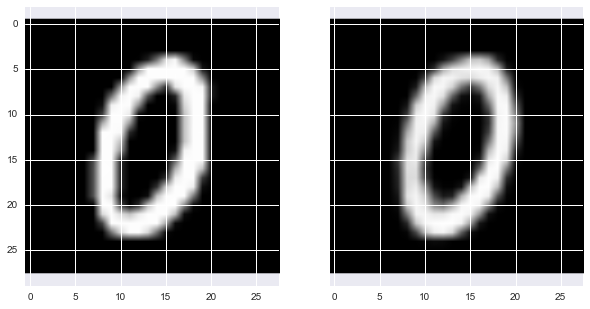

In [370]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
i = 15
plt_ = axes[0].imshow(x_sample[i].reshape(28, 28), cmap="gray")
plt_ = axes[1].imshow(x_reconstruct[i].reshape(28, 28), cmap="gray") 

# END: Checking the restoreWeights function for MNIST

# BEGIN: Build Variational Mix Nets

In [5]:
class VariationlMixNet(object):
    """ Variation Mixture Net with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The Variational Mix Net requires
    a set of trained weights.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture1, network_architecture2, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture1
        self.network_architecture2 = network_architecture2
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, self.network_architecture["n_input"]])
        
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.network_weights = self._initialize_weights(**self.network_architecture)
        self.network_weights2 = self._initialize_weights(**self.network_architecture2)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq, self.z_mean_s, self.z_log_sigma_sq_s = \
            self._recognition_network(self.network_weights["weights_recog"], 
                                      self.network_weights["biases_recog"], 
                                      self.network_weights2["weights_recog"],
                                      self.network_weights2["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        eps_s = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        self.z_s = tf.add(self.z_mean_s, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq_s)), eps_s))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(self.network_weights["weights_gener"],
                                    self.network_weights["biases_gener"],
                                    self.network_weights2["weights_gener"],
                                    self.network_weights2["biases_gener"]) 
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        with tf.name_scope("encoder") as scope:
            all_weights['weights_recog'] = {
                'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
                'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
                'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
                'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
            all_weights['biases_recog'] = {
                'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
                'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
                'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
                'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        with tf.name_scope("decoder") as scope:
            all_weights['weights_gener'] = {
                'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
                'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
                'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
                'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
            all_weights['biases_gener'] = {
                'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
                'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
                'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
                'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases, weights2, biases2):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        
        # Network 1 (MNIST)
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
            
        # Network 2 (Synthesized) 
        layer_1_s = self.transfer_fct(tf.add(tf.matmul(self.x, weights2['h1']), 
                                           biases2['b1']))  
        layer_2_s = self.transfer_fct(tf.add(tf.matmul(layer_1_s, weights2['h2']), 
                                           biases2['b2'])) 
        z_mean_s = tf.add(tf.matmul(layer_2_s, weights2['out_mean']),
                        biases2['out_mean'])
        z_log_sigma_sq_s = \
            tf.add(tf.matmul(layer_2_s, weights2['out_log_sigma']), 
                   biases2['out_log_sigma'])
        return (z_mean, z_log_sigma_sq, z_mean_s, z_log_sigma_sq_s)

    def _generator_network(self, weights, biases, weights2, biases2):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        
        # Network 1 (MNIST)
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        self.x_reconstr_mean_m = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        # Network 2 (Synthesized)
        layer_1_s = self.transfer_fct(tf.add(tf.matmul(self.z_s, weights2['h1']), 
                                           biases2['b1'])) 
        layer_2_s = self.transfer_fct(tf.add(tf.matmul(layer_1_s, weights2['h2']), 
                                           biases2['b2'])) 
        self.x_reconstr_mean_s = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2_s, weights2['out_mean']), 
                                 biases2['out_mean']))
        x_reconstr_mean = 0.5 * (self.x_reconstr_mean_m + self.x_reconstr_mean_s)
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluatio of log(0.0)
        self.reconstr_loss = reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-4 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-4 + 1 - self.x_reconstr_mean),
                           1) 
        # self.reconstr_loss = reconstr_loss = tf.Print(reconstr_loss, [reconstr_loss], message="This is reconstr_loss: ")
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        self.latent_loss = latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        
        self.latent_loss_s = latent_loss_s = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq_s 
                                           - tf.square(self.z_mean_s) 
                                           - tf.exp(self.z_log_sigma_sq_s), 1)
        
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss + latent_loss_s)   # average over batch
        
        vars_enc = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
        
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost, var_list=vars_enc)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def debug(self, X):
        re, la = self.sess.run((self.reconstr_loss, self.latent_loss), feed_dict={self.x: X})
        return (re, la)
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run([self.x_reconstr_mean, self.x_reconstr_mean_m, self.x_reconstr_mean_s], 
                             feed_dict={self.x: X})
    
    def restoreWeights(self, all_weights):
        self.restoreDictWeights(self.network_weights, all_weights["mnist"])
        self.restoreDictWeights(self.network_weights2, all_weights["syn"])
        
    def restoreDictWeights(self, network_weights, weights_dict):
        assign_op1 = network_weights["weights_recog"]["h1"].assign(weights_dict["weights_recog"]["h1"])
        assign_op2 = network_weights["weights_recog"]["h2"].assign(weights_dict["weights_recog"]["h2"])
        assign_op3 = network_weights["weights_recog"]["out_mean"].assign(weights_dict["weights_recog"]["out_mean"])
        assign_op4 = network_weights["weights_recog"]["out_log_sigma"].assign(weights_dict["weights_recog"]["out_log_sigma"])
        self.sess.run([assign_op1, assign_op2, assign_op3, assign_op4])
        assign_op1 = network_weights["biases_recog"]["b1"].assign(weights_dict["biases_recog"]["b1"])
        assign_op2 = network_weights["biases_recog"]["b2"].assign(weights_dict["biases_recog"]["b2"])
        assign_op3 = network_weights["biases_recog"]["out_mean"].assign(weights_dict["biases_recog"]["out_mean"])
        assign_op4 = self.network_weights["biases_recog"]["out_log_sigma"].assign(weights_dict["biases_recog"]["out_log_sigma"])
        self.sess.run([assign_op1, assign_op2, assign_op3, assign_op4])
        assign_op1 = network_weights["weights_gener"]["h1"].assign(weights_dict["weights_gener"]["h1"])
        assign_op2 = network_weights["weights_gener"]["h2"].assign(weights_dict["weights_gener"]["h2"])
        assign_op3 = network_weights["weights_gener"]["out_mean"].assign(weights_dict["weights_gener"]["out_mean"])
        assign_op4 = network_weights["weights_gener"]["out_log_sigma"].assign(weights_dict["weights_gener"]["out_log_sigma"])
        self.sess.run([assign_op1, assign_op2, assign_op3, assign_op4])
        assign_op1 = network_weights["biases_gener"]["b1"].assign(weights_dict["biases_gener"]["b1"])
        assign_op2 = network_weights["biases_gener"]["b2"].assign(weights_dict["biases_gener"]["b2"])
        assign_op3 = network_weights["biases_gener"]["out_mean"].assign(weights_dict["biases_gener"]["out_mean"])
        assign_op4 = network_weights["biases_gener"]["out_log_sigma"].assign(weights_dict["biases_gener"]["out_log_sigma"])
        self.sess.run([assign_op1, assign_op2, assign_op3, assign_op4])
    
    def getWeights(self):
        all_weights = dict()
        all_weights["mnist"] = self.getDictWeights(self.network_weights)
        all_weights["syn"] = self.getDictWeights(self.network_weights2)
        return all_weights 
    
    def getDictWeights(self, network_weights):
        all_weights = dict() 
        all_weights['weights_recog'] = {
            'h1': self.sess.run(network_weights['weights_recog']['h1']),
            'h2': self.sess.run(network_weights['weights_recog']['h2']),
            'out_mean': self.sess.run(network_weights['weights_recog']['out_mean']),
            'out_log_sigma': self.sess.run(network_weights['weights_recog']['out_log_sigma'])}
        all_weights['biases_recog'] = {
            'b1': self.sess.run(network_weights['biases_recog']['b1']),
            'b2': self.sess.run(network_weights['biases_recog']['b2']),
            'out_mean': self.sess.run(network_weights['biases_recog']['out_mean']),
            'out_log_sigma': self.sess.run(network_weights['biases_recog']['out_log_sigma'])}
        all_weights['weights_gener'] = {
            'h1': self.sess.run(network_weights['weights_gener']['h1']), 
            'h2': self.sess.run(network_weights['weights_gener']['h2']), 
            'out_mean': self.sess.run(network_weights['weights_gener']['out_mean']), 
            'out_log_sigma': self.sess.run(network_weights['weights_gener']['out_log_sigma'])}
        all_weights['biases_gener'] = {
            'b1': self.sess.run(network_weights['biases_gener']['b1']),
            'b2': self.sess.run(network_weights['biases_gener']['b2']),
            'out_mean': self.sess.run(network_weights['biases_gener']['out_mean']),
            'out_log_sigma': self.sess.run(network_weights['biases_gener']['out_log_sigma'])}
        return all_weights 

# Create a training set of mixed data

## First, fix the unscaled issue in the Synthesized data, and re-save the scaled dataset.

In [556]:
with open("./BayesMixNet/syn_data_train.pickle", "rb") as f:
    syn_data_train = pickle.load(f)

In [557]:
syn_data_train /= 255
print(np.mean(syn_data_train))
print(np.std(syn_data_train))

0.0917274234694
0.288640785845


In [558]:
def normalizeData2(patches):
    # subtract its mean and truncate it  to -/+3*std
    patches = patches - np.mean(patches)
    pstd = np.std(patches)
    patches /= pstd
    
    # rescale from [-1, 1] to [0.1, 0.9] 
    # patches = (patches + 1) * 0.4 + 0.1
    return patches

In [559]:
syn_data_train = normalizeData2(syn_data_train)

In [560]:
syn_data_train.shape

(50000, 784)

In [561]:
print(np.mean(syn_data_train))
print(np.std(syn_data_train))

5.23142164509e-16
1.0


In [562]:
with open("./BayesMixNet/syn_data_train.pickle", "wb") as f:
    pickle.dump(syn_data_train, f)

In [563]:
with open("./BayesMixNet/syn_data_test.pickle", "rb") as f:
    syn_data_test = pickle.load(f)

In [564]:
syn_data_test /= 255
print(np.mean(syn_data_test))
print(np.std(syn_data_test))

0.0920121173469
0.289043054939


In [565]:
syn_data_test = normalizeData2(syn_data_test)

In [566]:
print(np.mean(syn_data_test))
print(np.std(syn_data_test))

-9.64779276877e-17
1.0


In [567]:
with open("./BayesMixNet/syn_data_test.pickle", "wb") as f:
    pickle.dump(syn_data_test, f)

In [573]:
np.max(mnist.train.images)

1.0

In [6]:
# MNIST + Synthetic image generator
# You can check an example of the images like this:
# % matplotlib inline 
# images, alphas = generateSynthetic(10)
# print(images.shape)
# print(alphas[1])
# plt_out = plt.imshow(images[1].reshape(28,28), cmap="gray")
def generateMixed(which): # n = training examples  
    if which == "train":
        with open("./BayesMixNet/syn_data_train.pickle", "rb") as f:
            syn_data = pickle.load(f)
        n_samples, _ = syn_data.shape
        mnist_data = mnist.train.images[:n_samples]
    if which == "test":
        with open("./BayesMixNet/syn_data_test.pickle", "rb") as f:
            syn_data = pickle.load(f)
        n_samples, _ = syn_data.shape
        mnist_data = mnist.test.images[:n_samples]
    mix_data = np.clip(syn_data + mnist_data, 0, 1)
    return mix_data

In [9]:
mix_data_train = generateMixed("train")

In [10]:
mix_data_train.shape

(50000, 784)

In [11]:
np.random.shuffle(mix_data_train)

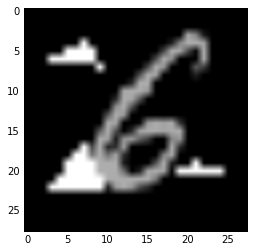

In [12]:
pltt = plt.imshow(mix_data_train[0].reshape(28, 28), cmap="gray")

In [626]:
with open("./BayesMixNet/mix_data_train.pickle", "wb") as f:
    pickle.dump(mix_data_train, f)

# END : Create a training set of mixed data

# BEGIN : Training

In [13]:
def train_mixed(training_epochs, batch_size, display_step):
    with tf.Graph().as_default():
        network_architecture = \
            dict(n_hidden_recog_1=500, # 1st layer encoder neurons
                 n_hidden_recog_2=500, # 2nd layer encoder neurons
                 n_hidden_gener_1=500, # 1st layer decoder neurons
                 n_hidden_gener_2=500, # 2nd layer decoder neurons
                 n_input=784, # MNIST data input (img shape: 28*28)
                 n_z=20)  # dimensionality of latent space
        #def train(network_architecture, learning_rate=0.001,
        #          batch_size=100
        vae_test = VariationlMixNet(network_architecture, network_architecture,
                                         learning_rate=0.001, 
                                         batch_size=100)

        with open("./BayesMixNet/mnist_weights_ae.pickle", "rb") as f:
            m_weights = pickle.load(f)
        with open("./BayesMixNet/syn_weights_ae.pickle", "rb") as f:
            s_weights = pickle.load(f)
        all_weights = {"mnist": m_weights, "syn": s_weights}
        vae_test.restoreWeights(all_weights)

        # visualizeImage(15, vae_test, "syn")  -> Looks good! The weights are sucessfully restored.

        # Now it's time for training. 

        # Training cycle
        n_samples, _ = mix_data_train.shape
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(n_samples / batch_size)
            # Loop over all batches
            for i in range(total_batch):
                # batch_xs, _ = mnist.train.next_batch(batch_size)
                batch_xs = get_random_block_from_data(mix_data_train, batch_size)

                cost = vae_test.partial_fit(batch_xs)
                # Compute average loss
                avg_cost += cost / n_samples * batch_size

            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), \
                      "cost=", "{:.9f}".format(avg_cost))
    return vae_test

In [16]:
vae_mix = train_mixed(training_epochs=10, batch_size=100, display_step=1)

Epoch: 0001 cost= 225.607330933
Epoch: 0002 cost= 218.621547333
Epoch: 0003 cost= 217.053580017
Epoch: 0004 cost= 216.396262695
Epoch: 0005 cost= 214.998882874
Epoch: 0006 cost= 214.674085327
Epoch: 0007 cost= 214.253919769
Epoch: 0008 cost= 213.618989655
Epoch: 0009 cost= 213.597838226
Epoch: 0010 cost= 214.143911224


In [32]:
mix_data_test = generateMixed("test")
mix_data_test.shape
np.random.shuffle(mix_data_test)

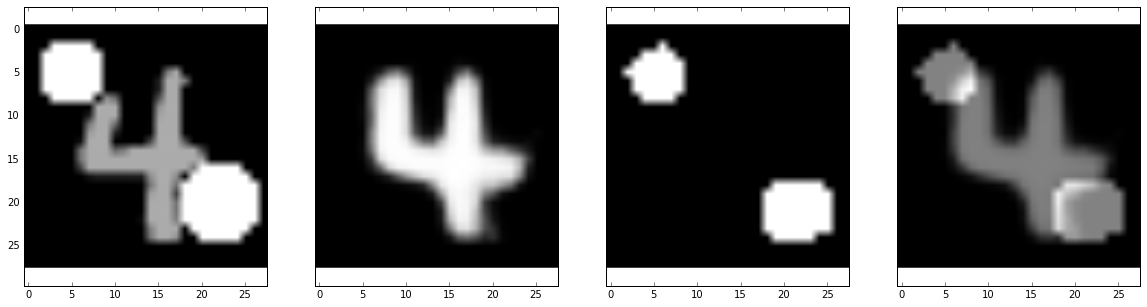

In [34]:
visualizeImage(51, vae_mix, "mix") 

In [ ]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    with tf.Graph().as_default():
        vae = VariationalAutoencoder(network_architecture, 
                                     learning_rate=learning_rate, 
                                     batch_size=batch_size)
        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(n_samples / batch_size)
            # Loop over all batches
            for i in range(total_batch):
                # batch_xs, _ = mnist.train.next_batch(batch_size)
                batch_xs = get_random_block_from_data(syn_data_train, batch_size)

                # Fit training using batch data
#                 if epoch >= 3:
#                     re, la = vae.debug(batch_xs)
#                     print(re)
#                     print(la)
                cost = vae.partial_fit(batch_xs)
                # Compute average loss
                avg_cost += cost / n_samples * batch_size

            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), \
                      "cost=", "{:.9f}".format(avg_cost))
    return vae

In [30]:
def visualizeImage(i, vae_mnist, data):
    if data == "mix":
        x_sample = mix_data_test[:100] # the 100 here is maching with the batchsize in training mixed_vae
        x_mix, x_m, x_s = vae_mnist.reconstruct(x_sample)
        fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
        plt_ = axes[0].imshow(x_sample[i].reshape(28, 28), cmap="gray")
        plt_ = axes[1].imshow(x_m[i].reshape(28, 28), cmap="gray")
        plt_ = axes[2].imshow(x_s[i].reshape(28, 28), cmap="gray")
        plt_ = axes[3].imshow(x_mix[i].reshape(28, 28), cmap="gray")
    else:
        if data == "mnist":
            x_sample = mnist.test.next_batch(100)[0]
            _ , x_reconstruct, _ = vae_mnist.reconstruct(x_sample)
        if data == "syn":
            x_sample = syn_data_test[:100]
            _ , _, x_reconstruct = vae_mnist.reconstruct(x_sample)


        fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
        plt_ = axes[0].imshow(x_sample[i].reshape(28, 28), cmap="gray")
        plt_ = axes[1].imshow(x_reconstruct[i].reshape(28, 28), cmap="gray") 

In [522]:
class VariationlMixNetTest(object):
    """ Variation Mixture Net with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The Variational Mix Net requires
    a set of trained weights.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture1, network_architecture2, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture1
        self.network_architecture2 = network_architecture2
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, self.network_architecture["n_input"]])
        
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        # self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.Session()
        self.sess.run(init)
        
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.network_weights = network_weights = self._initialize_weights(**self.network_architecture)
        self.network_weights2 = network_weights2 = self._initialize_weights(**self.network_architecture2)

        
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        with tf.name_scope("encoder") as scope:
            all_weights['weights_recog'] = {
                'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
                'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
                'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
                'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
            all_weights['biases_recog'] = {
                'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
                'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
                'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
                'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        with tf.name_scope("decoder") as scope:
            all_weights['weights_gener'] = {
                'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
                'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
                'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
                'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
            all_weights['biases_gener'] = {
                'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
                'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
                'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
                'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights

In [523]:
with tf.Graph().as_default():
    network_architecture = \
        dict(n_hidden_recog_1=500, # 1st layer encoder neurons
             n_hidden_recog_2=500, # 2nd layer encoder neurons
             n_hidden_gener_1=500, # 1st layer decoder neurons
             n_hidden_gener_2=500, # 2nd layer decoder neurons
             n_input=784, # MNIST data input (img shape: 28*28)
             n_z=20)  # dimensionality of latent space
    #def train(network_architecture, learning_rate=0.001,
    #          batch_size=100
    vae_test = VariationlMixNetTest(network_architecture, network_architecture,
                                     learning_rate=0.001, 
                                     batch_size=100)
            # vars_enc = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
    tvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
    for node in tvars:
        print(node.name)

encoder/Variable:0
encoder/Variable_1:0
encoder/Variable_2:0
encoder/Variable_3:0
encoder/Variable_4:0
encoder/Variable_5:0
encoder/Variable_6:0
encoder/Variable_7:0
encoder_1/Variable:0
encoder_1/Variable_1:0
encoder_1/Variable_2:0
encoder_1/Variable_3:0
encoder_1/Variable_4:0
encoder_1/Variable_5:0
encoder_1/Variable_6:0
encoder_1/Variable_7:0
